In [52]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm
from keybert import KeyBERT
from scipy.sparse import save_npz
import joblib

In [53]:
df = pd.read_csv('../data/processed/items_cleaned.csv')
df

,Title,Author,Publisher,Subjects,item_id,Subjects_list
0,classification décimale universelle édition ab...,unknown author,ed du cefal,classification décimale universelle; indexatio...,0,"['classification décimale universelle', ' inde..."
1,les interactions dans lenseignement des langue...,cicurel francine 1947,didier,didactiquelangue étrangère enseignement; didac...,1,"['didactiquelangue étrangère enseignement', ' ..."
2,histoire de vie et recherche biographique pers...,unknown author,lharmattan,histoires de vie en sociologie; sciences socia...,2,"['histoires de vie en sociologie', ' sciences ..."
3,ce livre devrait me permettre de résoudre le c...,mazas sylvain 1980,vraoum,moyenorient; bandes dessinées autobiographique...,3,"['moyenorient', ' bandes dessinées autobiograp..."
4,les années glorieuses roman,lemaitre pierre 1951,calmannlévy,france19451975; roman historique; roman frança...,4,"['france19451975', ' roman historique', ' roma..."
...,...,...,...,...,...,...
15286,le vagabond de tokyo,fukutani takashi 19522000,le lezard noir,mangas,15286,['mangas']
15287,god of high school le match contre les dieux,park yongje,kbooks,unknown subjects,15287,['unknown subjects']
15288,blue lock,kaneshiro muneyuki,pika,compétitions; football; entraînement sports; s...,15288,"['compétitions', ' football', ' entraînement s..."
15289,red eyes sword akame ga kill zero,takahiro,kurokawa,bandes dessinées; mangas,15289,"['bandes dessinées', ' mangas']"


In [54]:
# Calculate subjects'unknown'
unknown_keyword_count = df['Subjects'].astype(str).str.contains('unknown', case=False, na=False).sum()

total_rows = len(df)

percentage_unknown_keywords = (unknown_keyword_count / total_rows) * 100
perectage_known_keywords = 100 - percentage_unknown_keywords

print(f"Total subjects containing 'unknown' keyword: {unknown_keyword_count}")
print(f"Total rows in DataFrame: {total_rows}")
print(f"Percentage of subjects containing 'unknown' keyword: {percentage_unknown_keywords:.2f}%")
print(f"Perentage of subjects not containing 'unkown' keywords: {perectage_known_keywords:.2f}%")

Total subjects containing 'unknown' keyword: 2223
Total rows in DataFrame: 15291
Percentage of subjects containing 'unknown' keyword: 14.54%
Perentage of subjects not containing 'unkown' keywords: 85.46%


Because we have 14.54% of unkown subject, we can try to enrich our training data by guessing the missing subjects from the titles.

# Guess missing subjects

To guess missing subject we will use a keyword extractor called "[KeyBERT](https://maartengr.github.io/KeyBERT/)"

In [55]:
kw_model = KeyBERT()
tqdm.pandas()

def guess_subjects(title):
    keywords = kw_model.extract_keywords(title, top_n=3)
    return ", ".join([k[0] for k in keywords])

In [56]:
mask = df['Subjects'].astype(str).str.contains('unknown', case=False, na=False)

print(f">>>Processing {mask.sum()} rows...")

df.loc[mask, 'guessed_subjects'] = df.loc[mask, 'Title'].progress_apply(guess_subjects)

>>>Processing 2223 rows...


  0%|          | 0/2223 [00:00<?, ?it/s]

In [57]:
print("\n--- Preview of Guessed subjects---")
display(df.loc[mask, ['Title', 'guessed_subjects']].head(30))


--- Preview of Guessed subjects---


,Title,guessed_subjects
47,la fille à la moto,"moto, fille, la"
83,lora del caffè manuale di conversazione per ge...,"manuale, generazioni, caffè"
85,monsieur remarquable,"remarquable, monsieur"
98,regarde les lumières mon amour,"amour, lumières, regarde"
121,le veilleur de lune,"veilleur, lune, le"
122,schtinki un sanglier au caractère de cochon in...,"dune, histoire, cochon"
127,recitatif a story,"recitatif, story"
136,et dieu riait beaucoup roman,"roman, beaucoup, et"
138,miracle à la combe aux aspics,"combe, miracle, aux"
139,un miracle roman,"roman, miracle"


Since guessing the keywords do not lead to that relevant information for the book subject (especially for short titles), we will focus on powerfull embeddings rather than labelling as the real goal of our system is to recommend similar books, not to label them correctly.



In [58]:
df.drop(columns=['guessed_subjects'], inplace=True)

# TF-IDF Vectorization (baseline semantic model)

TF-IDF transforms textual descriptions into numerical vectors by assigning importance to words according to how unique they are across the dataset. **We used a 1-2 n-gram range to capture both individual keywords and meaningful word pairs such as "science fiction" or "historical novel", improving semantic representation without excessive dimensionality.**

In [59]:
df['text_for_model'] = df.apply(
    lambda row: row['Title'] if row['Subjects'] == "unknown subject"
    else f"{row['Title']} {row['Subjects']}",
    axis=1
)
df.head(10)

,Title,Author,Publisher,Subjects,item_id,Subjects_list,text_for_model
0,classification décimale universelle édition ab...,unknown author,ed du cefal,classification décimale universelle; indexatio...,0,"['classification décimale universelle', ' inde...",classification décimale universelle édition ab...
1,les interactions dans lenseignement des langue...,cicurel francine 1947,didier,didactiquelangue étrangère enseignement; didac...,1,"['didactiquelangue étrangère enseignement', ' ...",les interactions dans lenseignement des langue...
2,histoire de vie et recherche biographique pers...,unknown author,lharmattan,histoires de vie en sociologie; sciences socia...,2,"['histoires de vie en sociologie', ' sciences ...",histoire de vie et recherche biographique pers...
3,ce livre devrait me permettre de résoudre le c...,mazas sylvain 1980,vraoum,moyenorient; bandes dessinées autobiographique...,3,"['moyenorient', ' bandes dessinées autobiograp...",ce livre devrait me permettre de résoudre le c...
4,les années glorieuses roman,lemaitre pierre 1951,calmannlévy,france19451975; roman historique; roman frança...,4,"['france19451975', ' roman historique', ' roma...",les années glorieuses roman france19451975; ro...
5,100 idées pour mieux gérer les troubles de lat...,lussier francine,tom pousse,trouble déficitaire de lattention avec ou sans...,5,['trouble déficitaire de lattention avec ou sa...,100 idées pour mieux gérer les troubles de lat...
6,la boite a outils des formateurs 71 outils cle...,bouchut fabienne,dunod,formateurs education des adultesformation; per...,6,"['formateurs education des adultesformation', ...",la boite a outils des formateurs 71 outils cle...
7,lautorité éducative dans la classe douze situa...,robbes bruno,esf éd,autoritérelation maîtreélève; autoritéenseigne...,7,"['autoritérelation maîtreélève', ' autoritéens...",lautorité éducative dans la classe douze situa...
8,un autre regard sur le climat,emma dessinatrice 1981,massot,climatdétérioration; bandes dessinées,8,"['climatdétérioration', ' bandes dessinées']",un autre regard sur le climat climatdétériorat...
9,le mirage de la croissance verte,auffret anthony,delcourt,développement économiqueaspect environnemental...,9,['développement économiqueaspect environnement...,le mirage de la croissance verte développement...


In [60]:
tfidf = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1,2),
    stop_words='english'
)
corpus = df['text_for_model'].tolist()

tfidf_matrix = tfidf.fit_transform(tqdm(corpus))

  0%|          | 0/15291 [00:00<?, ?it/s]

In [61]:
print(">>> TF-IDF matrix shape:", tfidf_matrix.shape)

feature_names = tfidf.get_feature_names_out()
print("\n Number of features:", len(feature_names))
print("First 30 features:", feature_names[:30])

>>> TF-IDF matrix shape: (15291, 15000)

 Number of features: 15000
First 30 features: ['000' '10' '10 ans' '10 décembre' '10 und' '100' '100 ans' '100 fiches'
 '100 films' '100 idées' '100 mots' '100 questions' '100 recettes' '1000'
 '101' '108' '10e' '10s' '11' '11 klasse' '111' '111 lieux' '11e'
 '11e sciences' '11e sdocument' '11s' '11s option' '12' '12 ans'
 '12 septembre']


In [62]:
book_index = 5
vector = tfidf_matrix[book_index].toarray()[0]

important_words = pd.DataFrame({
    'word': feature_names,
    'tfidf_score': vector
}).sort_values(by='tfidf_score', ascending=False).head(15)

print(f">>> For this book, TF-IDF considers these words most representative:")
important_words

>>> For this book, TF-IDF considers these words most representative:


,word,tfidf_score
7996,lattention,0.415021
13710,troubles lattention,0.328413
13702,troubles,0.235479
4797,enfants,0.194066
6710,gérer les,0.175645
9105,mieux gérer,0.175645
4799,enfants atteints,0.169097
1110,atteints,0.169097
1111,atteints troubles,0.169097
4813,enfants hyperactifs,0.166498


## Save TF-IDF

In [63]:
save_npz("../data/artifacts/tfidf_matrix.npz", tfidf_matrix)
joblib.dump(tfidf, "../data/artifacts/tfidf_vectorizer.joblib")

['../data/artifacts/tfidf_vectorizer.joblib']

# MiniLM embeddings

We used the all-MiniLM-L6-v2 transformer to capture context and meaning. This creates a compact, dense vector (384 dimensions) where books with similar themes are mathematically close to each other, even if they do not share exact keywords.

In [64]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df['text_for_model'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/478 [00:00<?, ?it/s]

In [65]:
print(">>> MiniLM Matrix Shape:", embeddings.shape)
print(">>> Example embedding vector length:", len(embeddings[0]))
print(">>> First 10 values of first embedding:\n", embeddings[0][:10])

>>> MiniLM Matrix Shape: (15291, 384)
>>> Example embedding vector length: 384
>>> First 10 values of first embedding:
 [-0.03424533 -0.06580156 -0.03238916 -0.0511941  -0.04582872  0.00086211
  0.01935077  0.05002768 -0.06710488  0.01834985]


In [66]:
book_index = 5
single_embedding = embeddings[book_index]

print(f"Book {book_index} embedding shape: {single_embedding.shape}")
print(f"First 10 dimensions: {single_embedding[:10]}")
print(f"Embedding stats - Min: {single_embedding.min():.3f}, "
      f"Max: {single_embedding.max():.3f}, "
      f"Mean: {single_embedding.mean():.3f}")

Book 5 embedding shape: (384,)
First 10 dimensions: [ 0.06124384 -0.00350301  0.04931434  0.02343353  0.01272666  0.0796698
  0.02087088  0.11792568 -0.15781294  0.07672698]
Embedding stats - Min: -0.158, Max: 0.180, Mean: -0.002


Each book is now represented as a point in a 384-dimensional semantic space, where similar books lie closer together.

In [67]:
book_a = 0
book_b = 1

similarity = cosine_similarity(
    [embeddings[book_a]],
    [embeddings[book_b]]
)[0][0]

print(f"Book A title: {df.iloc[book_a]['Title']}")
print(f"Book B title: {df.iloc[book_b]['Title']}")
print(f"Semantic similarity score: {similarity:.4f}")

Book A title: classification décimale universelle édition abrégée
Book B title: les interactions dans lenseignement des langues agir professoral et pratiques de classe
Semantic similarity score: 0.0738


In [68]:
def get_similar_books(book_index, top_n=5):
    scores = cosine_similarity(
        [embeddings[book_index]],
        embeddings
    )[0]

    similar_indices = scores.argsort()[::-1][1:top_n+1]

    print("Reference book:", df.iloc[book_index]["Title"])
    print("\nMost similar books:")

    for idx in similar_indices:
        print("-", df.iloc[idx]["Title"], "| score:", scores[idx])

get_similar_books(8)

Reference book: un autre regard sur le climat

Most similar books:
- urgence climatique il est encore temps | score: 0.6872903
- chauds comme le climat | score: 0.67072815
- tout comprendre ou presque sur le climat | score: 0.65732384
- urgence climatique il est encore temps | score: 0.64893746
- histoire du climat depuis lan mil | score: 0.6339295


Since the book was rated multiple times **by different users**, it is possible for it to appear multiple times in the dataset. Let's create a temporary variable that will have only unique books.

## Inspecting & visualising Unique MiniLM embeddings

In [69]:
def plot_embeddings_with_subjects(embeddings, unique_df, n_points=1000):
    # Sample points
    if n_points > len(embeddings):
        n_points = len(embeddings)

    idx = np.random.choice(len(embeddings), n_points, replace=False)
    sampled_embeddings = embeddings[idx]
    sampled_subjects = unique_df.iloc[idx]['Subjects']

    # Reduce dimensions
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(sampled_embeddings)

    plot_df = pd.DataFrame({
        'x': reduced[:,0],
        'y': reduced[:,1],
        'subject': sampled_subjects
    })

    plt.figure(figsize=(10,7))
    sns.scatterplot(
        data=plot_df,
        x='x',
        y='y',
        legend=False,
        alpha=0.7
    )
    plt.title(f"MiniLM Embedding Space (colored by Subject) - {n_points} books")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.show()

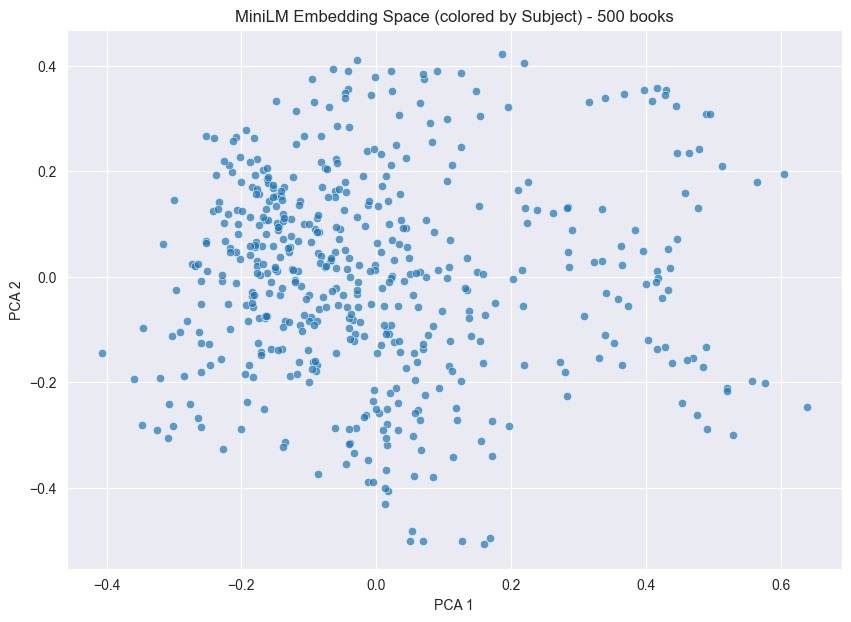

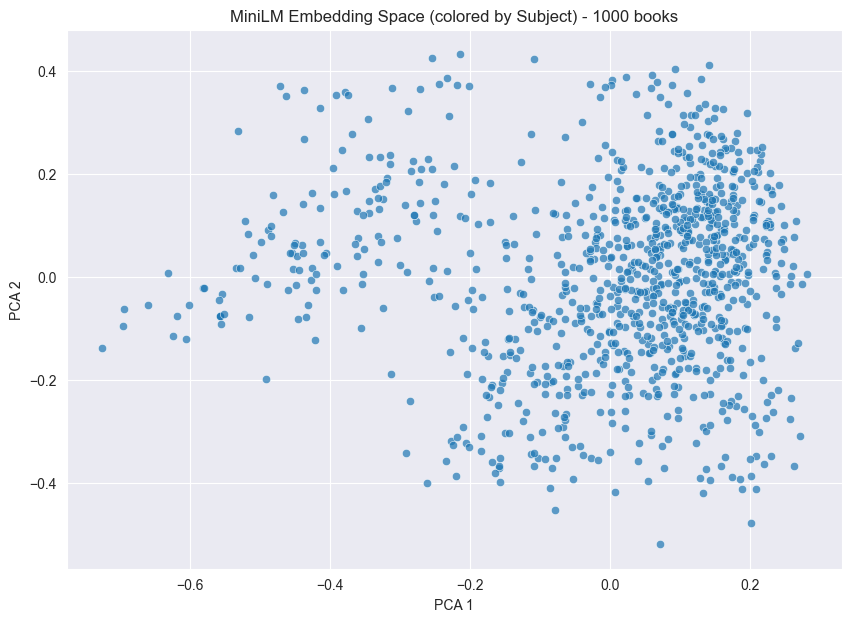

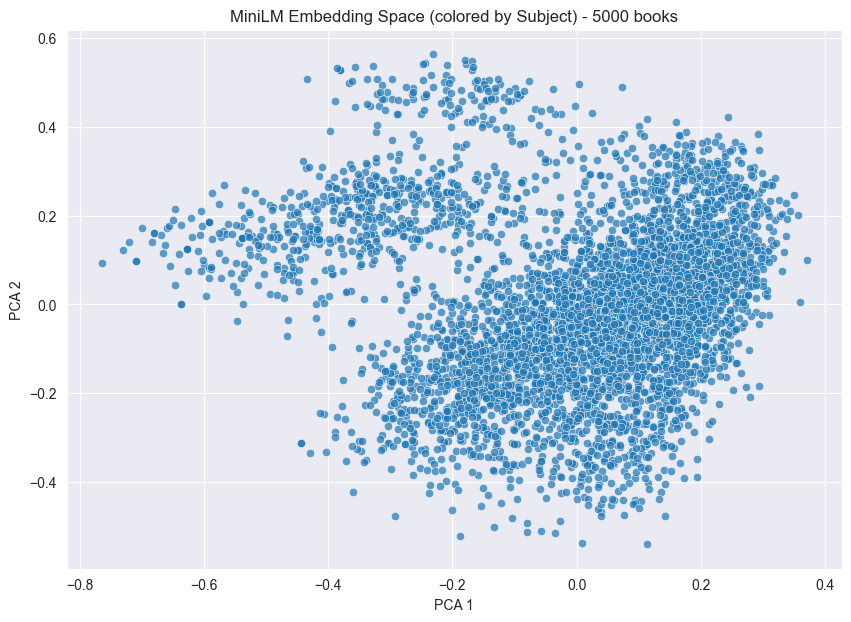

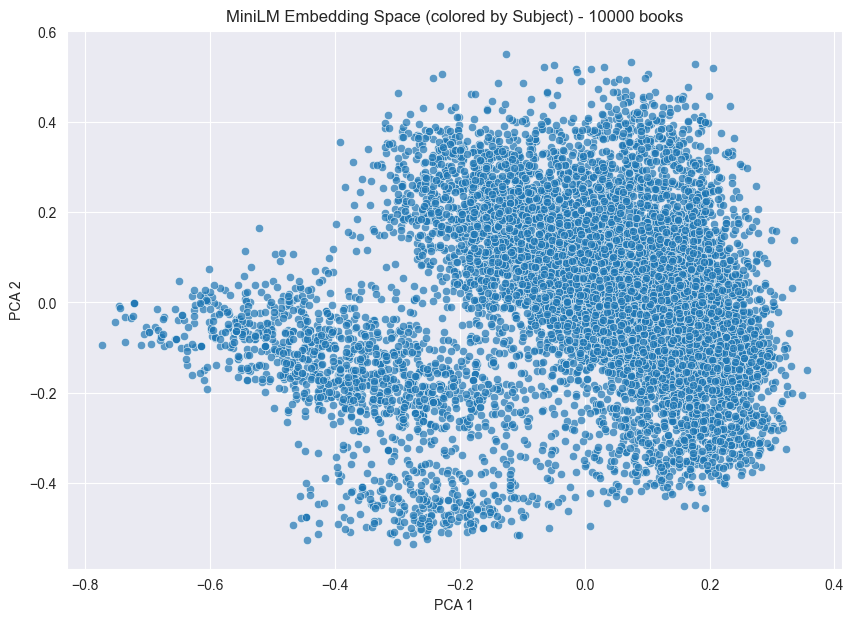

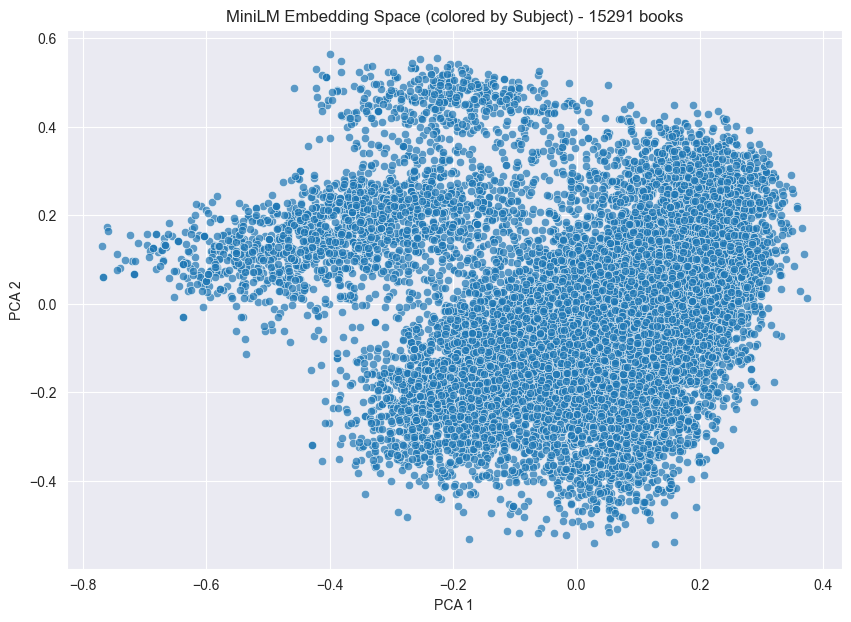

In [70]:
num_books = [500, 1000, 5000, 10000, len(embeddings)]

for book_count in num_books:
    plot_embeddings_with_subjects(embeddings, df, book_count)

PCA reduces high-dimensional embeddings into two dimensions for visualisation. PCA1 and PCA2 do not represent explicit features but are abstract components that preserve as much semantic variance as possible. Their purpose is to illustrate clustering and relative proximity between books.

- Clusters = books with similar themes
- Separation = distinct categories

# Save embeddings

In [71]:
np.save("../data/artifacts/minilm_embeddings.npy", embeddings)